# Text Processing

Pos-tag abbreviation: \
https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

### Packages

In [8]:
import pandas as pd
import numpy as np
import nltk
from nltk.collocations import *
import copy
import matplotlib.pyplot as plt
import time
import csv
import seaborn as sns

## Read in Small Data (metadata)

In [2]:
code = 'vie'
text_type1 = 'Abstract'
text_type2 = 'Tiab'
dpi=300

In [81]:
#md = pd.read_csv('mt_country/'+code+'.csv')
md = pd.read_csv('mt_year/yall.csv')

In [4]:
#foo = mt_comb[(mt_comb['JPN']==False) & (mt_comb['KOR']==False) & (mt_comb['SGP']==False) & (mt_comb['THA']==False) &
#             (mt_comb['MYS']==False) & (mt_comb['VNM']==False) & (mt_comb['IDN']==False) & (mt_comb['PHL']==True)]
#len(foo)

## Preprocessing abstract

### Separate based on Part-of-Speech Tagging

In [82]:
import nltk
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *
stemmer = PorterStemmer()
wt = word_tokenize

abs_w = md[text_type1]

noun_tag = ['NN', 'NNS', 'NNP', 'NNPS'] 
verb_tag = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
adj_tag = ['JJ']
alt_tag = ['FW', 'SYM', '$']
incw_tag = noun_tag + adj_tag + alt_tag
incs_tag = noun_tag + verb_tag + adj_tag + alt_tag
verb_exc = ['be', 'is', 'are', 'do', 'does', 'did', 'has', 'have', 'had', 'been', 'was', 'were']

exc = []
inc = []
psn = []
psj = []
psv = []

for line in abs_w: 
    token = wt(line)
    pos = nltk.pos_tag(token)
    
    pos_i = [word for word in pos if any(tag in word for tag in incw_tag)]
    pos_i = [word for word in pos_i if not any(tag in word for tag in verb_exc)]
    dtf = pd.DataFrame(pos_i)
    abs_i = dtf.loc[:, 0].tolist()
    inc.append(' '.join(abs_i))
    
    pos_e = [word for word in pos if not any(tag in word for tag in incs_tag)]
    dtf = pd.DataFrame(pos_e)
    abs_e = dtf.loc[:, 0].tolist()
    exc.append(' '.join(abs_e))
    
    pos_n = [word for word in pos if any(tag in word for tag in (noun_tag + alt_tag))]
    dtf = pd.DataFrame(pos_n)
    abs_n = dtf.loc[:, 0].tolist()
    psn.append(' '.join(abs_n))
    
    pos_j = [word for word in pos if any(tag in word for tag in adj_tag)]
    if len(pos_j)>0:
        dtf = pd.DataFrame(pos_j)        
    else:
        dtf = pd.DataFrame({0: [''], 1: ['']})
    abs_j = dtf.loc[:, 0].tolist()
    psj.append(' '.join(abs_j))
     
    pos_v = [word for word in pos if any(tag in word for tag in (verb_tag))]
    pos_v = [word for word in pos_v if not any(tag in word for tag in verb_exc)]
    if len(pos_v)>0:
        dtf = pd.DataFrame(pos_v)        
    else:
        dtf = pd.DataFrame({0: [''], 1: ['']})
    abs_v = dtf.loc[:, 0].tolist()
    psv.append(' '.join(abs_v))

md['noun'] = psn
md['adjective'] = psj
md['verb'] = psv
md['PA'] = inc
md['els'] = exc

#md['els'][md['els'].str.contains('RNA')]

### Remove characters and short word, lowercase, lemmatize

In [83]:
#Remove characters and short word, lowercase, lemmatize
md['CA'] = md['PA'].str.replace('[^a-zA-Z0-9]', ' ')

md['CA'] = md['CA'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

md['CA'] = md['CA'].apply(lambda x: x.lower())

stop_words = stopwords.words('english')
md['CA'] = md['CA'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

reg = '^\d(.*\d)?$'
md['CA'] = md['CA'].apply(lambda x: ' '.join([word for word in x.split() if not re.match(reg, word)]))

reg = '^-'
md['CA'] = md['CA'].apply(lambda x: ' '.join([(word.strip('-') if re.match(reg, word) else (word)) for word in x.split()]))

wt = word_tokenize
md['CA'] = md['CA'].apply(wt)

lmtzr = WordNetLemmatizer()
md['CA'] = md['CA'].apply(lambda x: ' '.join([lmtzr.lemmatize(word) for word in x]))

md['CA'] = md['CA'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

### Process collocated-trigram in corpus

In [84]:
#Extract trigram

trigram_measures = nltk.collocations.TrigramAssocMeasures()

fn = []
wn3 = []
for line in md['CA']:
    tt = word_tokenize(line)
    tg = TrigramCollocationFinder.from_words(tt)
    tg.apply_freq_filter(2)
    n3 = tg.nbest(trigram_measures.pmi, 10)
    wn3.append(n3)
    
md['trigram'] = wn3

In [85]:
#Count trigram

import collections
from collections import Counter

tgp = 0.05/100
t3 = [item for sublist in wn3 for item in sublist]
counts = Counter(t3)
dtc = pd.DataFrame({'word' : list(counts.keys()), 'counts' : list(counts.values())})
dwn3 = dtc.sort_values(by= ['counts'], ascending = False)
wn3f = dwn3.loc[(dwn3['counts'] > round(tgp*len(md))), 'word'].tolist()
print (round(tgp*len(md)), len(wn3f), wn3f)

11 67 [('next', 'generation', 'sequencing'), ('rrna', 'gene', 'sequence'), ('whole', 'exome', 'sequencing'), ('whole', 'genome', 'sequencing'), ('protein', 'coding', 'gene'), ('rna', 'seq', 'data'), ('single', 'copy', 'region'), ('whole', 'genome', 'sequence'), ('rna', 'seq', 'analysis'), ('single', 'cell', 'rna'), ('cancer', 'cell', 'line'), ('non', 'coding', 'rna'), ('gene', 'expression', 'profile'), ('complete', 'genome', 'sequence'), ('complete', 'mitochondrial', 'genome'), ('breast', 'cancer', 'patient'), ('mir', 'mir', 'mir'), ('squamous', 'cell', 'carcinoma'), ('high', 'throughput', 'sequencing'), ('pluripotent', 'stem', 'cell'), ('polymerase', 'chain', 'reaction'), ('wide', 'association', 'study'), ('breast', 'cancer', 'cell'), ('cell', 'lung', 'cancer'), ('real', 'time', 'pcr'), ('small', 'cell', 'lung'), ('high', 'fat', 'diet'), ('single', 'nucleotide', 'polymorphism'), ('genome', 'wide', 'association'), ('cancer', 'related', 'gene'), ('central', 'nervous', 'system'), ('cell'

In [87]:
#Replace word to trigram in each document 

ft3 = []
for line in md['CA']: 
    ft = []
    for n in wn3f: 
        w = ' '.join(n)
        nw = '_'.join(n)
        if len(ft) == 0: 
            nt = line.replace(w, nw)
            ft.append(nt)
        else :
            ft = ''.join(ft)
            ft = ft.replace(w, nw)
    ft = ''.join(ft)
    ft3.append(ft)

### Process collocated-bigram in corpus

In [128]:
#Extract bigram

bigram_measures = nltk.collocations.BigramAssocMeasures()

fm = []
wn2 = []
for line in ft3:
    tt = word_tokenize(line)
    tg = BigramCollocationFinder.from_words(tt)
    tg.apply_freq_filter(3)
    n2 = tg.nbest(bigram_measures.pmi, 10)
    wn2.append(n2)
    
md['bigram'] = wn2

In [250]:
#Count bigram

import collections
from collections import Counter

bgp = 0.075/100
t2 = [item for sublist in wn2 for item in sublist]
counts = Counter(t2)
dtc = pd.DataFrame({'word' : list(counts.keys()), 'counts' : list(counts.values())})
dwn2 = dtc.sort_values(by= ['counts'], ascending = False)
wn2f = dwn2.loc[(dwn2['counts'] > round(bgp*len(md))), 'word'].tolist()
print (round(bgp*len(md)), len(wn2f), wn2f)

16 98 [('gene', 'expression'), ('dna', 'methylation'), ('cell', 'line'), ('gut', 'microbiota'), ('breast', 'cancer'), ('rna', 'seq'), ('transcription', 'factor'), ('microbial', 'community'), ('somatic', 'mutation'), ('stem', 'cell'), ('single', 'cell'), ('bacterial', 'community'), ('gastric', 'cancer'), ('lung', 'cancer'), ('cancer', 'cell'), ('sars', 'cov'), ('cell', 'type'), ('target', 'gene'), ('wild', 'type'), ('hearing', 'loss'), ('type', 'strain'), ('colorectal', 'cancer'), ('pathogenic', 'variant'), ('candidate', 'gene'), ('rare', 'variant'), ('immune', 'response'), ('expression', 'level'), ('gene', 'mutation'), ('amino', 'acid'), ('gut', 'microbiome'), ('prostate', 'cancer'), ('genome', 'wide'), ('related', 'gene'), ('cd8', 'cell'), ('ovarian', 'cancer'), ('relative', 'abundance'), ('rrna', 'gene'), ('cancer', 'patient'), ('genetic', 'diversity'), ('cell', 'cycle'), ('chip', 'seq'), ('small', 'rna'), ('chloroplast', 'genome'), ('tumor', 'cell'), ('egfr', 'mutation'), ('whole', 

In [251]:
#Replace word to bigram in each document 

ft2 = []
for line in ft3: 
    ft = []
    for n in wn2f: 
        w = ' '.join(n)
        nw = '_'.join(n)
        if len(ft) == 0: 
            nt = line.replace(w, nw)
            ft.append(nt)
        else :
            ft = ''.join(ft)
            ft = ft.replace(w, nw)
    ft = ''.join(ft)
    ft2.append(ft)

## Vectorize word for filtering

In [256]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def tfidf_generator (corpus = '', no_features = ''):
    tv = TfidfVectorizer(max_df=0.9, min_df=0, max_features=no_features, token_pattern=r'\S+')
    tt = tv.fit_transform(corpus)
    cv = CountVectorizer(max_df=0.9, min_df=0, max_features=no_features, token_pattern=r'\S+')
    ct = cv.fit_transform(corpus)
    print (tt.shape, ct.shape)
    return tv, tt, cv, ct 

def wdf_generator(tv = '', tt = '', ct = ''):
    tt_t = tt.transpose()
    dt = tt.sum(axis=0).transpose().tolist()
    dc = ct.sum(axis=0).transpose().tolist()
    dn = [line.nnz for line in tt_t]
    dw = tv.get_feature_names()

    dft = pd.DataFrame(dt, columns = ['tf-idf'])
    dfc = pd.DataFrame(dc, columns = ['word count'])
    dfd = pd.DataFrame(dn, columns = ['document count'])
    dfw = pd.DataFrame(dw, columns = ['word'])

    df = pd.concat([dfw, dft, dfc, dfd],axis=1)
    df['tf-idf norm'] = (df['tf-idf']/df['tf-idf'].sum())*100
    df['word count norm'] = (df['word count']/df['word count'].sum())*100
    df['document count norm'] = (df['document count']/df['document count'].sum())*100
    print (len(df))
    return df

def visualize_df (dff = '', top_words = ''):
    dft = dff.sort_values(by = 'tf-idf', ascending = True, ignore_index = True).tail(top_words)
    dfd = dff.sort_values(by = 'document count', ascending = True, ignore_index = True).tail(top_words)
    dfc = dff.sort_values(by = 'word count', ascending = True, ignore_index = True).tail(top_words)

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(12,10))
    ax1.barh(width = dft['tf-idf norm'], y= dft['word'])
    ax1.set_title('Tf-idf value in corpus', size =12)
    ax1.set_xlabel('%  tf-idf value in corpus', size =12)

    ax2.barh(width = dfc['word count norm'], y= dfc['word'])
    ax2.set_title('Word count in corpus', size =12)
    #plt.xticks(rotation=90, size=18); plt.yticks(size=14)
    ax2.set_xlabel('% word count in corpus', size =12)

    ax3.barh(width = dfd['document count norm'], y= dfd['word'])
    ax3.set_title('Word apprearance in document', size =12)
    #plt.xticks(rotation=90, size=18); plt.yticks(size=14)
    ax3.set_xlabel('% appearance value in corpus', size =12)
    plt.tight_layout()
#    plt.savefig('biomic/dw.png', dpi=dpi)
    plt.show()

In [257]:
tv, tt, cv, ct = tfidf_generator(ft2, None)
df = wdf_generator(tv, tt, ct)
#visualize_df(df, 100)

(21309, 82919) (21309, 82919)
82919


## Word filtering

In [302]:
#explore feature name

fn = tv.get_feature_names()
fnn = [line for line in fn if line.startswith('nextseq')]
fnn

['nextseq', 'nextseq2500', 'nextseq500']

In [258]:
#create list word to be filtered out

csw1 = []
rcsw = ['background', 'introduction', 'purpose', 'method', 'approach', 'result', 'conclusion', 'data', 'inform', 'stud', 'analy', 'copyright',
        'use', 'based', 'find', 'aim', 'understa', 'genera', 'due', 'with', 'data', 'many', 'addit', 'howev', 'there', 'signif', 'further', 
        'high', 'low', 'common', 'importa', 'new', 'differ', 'similar', 'distinc', 'total', 'several', 'various', 'numbe']
for word in rcsw: 
    wcsw = [line for line in fn if line.startswith(word)]
    csw1.append(wcsw)
csw1 = [item for sublist in csw1 for item in sublist]
csw1 = [word for word in  csw1 if '_' not in word]

csw2 = []
rcsw = ['ful', 'cly', 'dly', 'ngly', 'hly', 'rily', 'aily', 'kly', 'lly', 'mly', 'nly', 'ely', 'rly', 'sly', 'tly', 'ruly', 'wly']
for word in rcsw: 
    wcsw = [line for line in fn if line.endswith(word)]
    csw2.append(wcsw)
csw2 = [item for sublist in csw2 for item in sublist]
csw2 = [word for word in csw2 if '_' not in word]

comm_sci_word = csw1 + csw2
len(comm_sci_word)

618

(21309, 82328) (21309, 82328)
82328


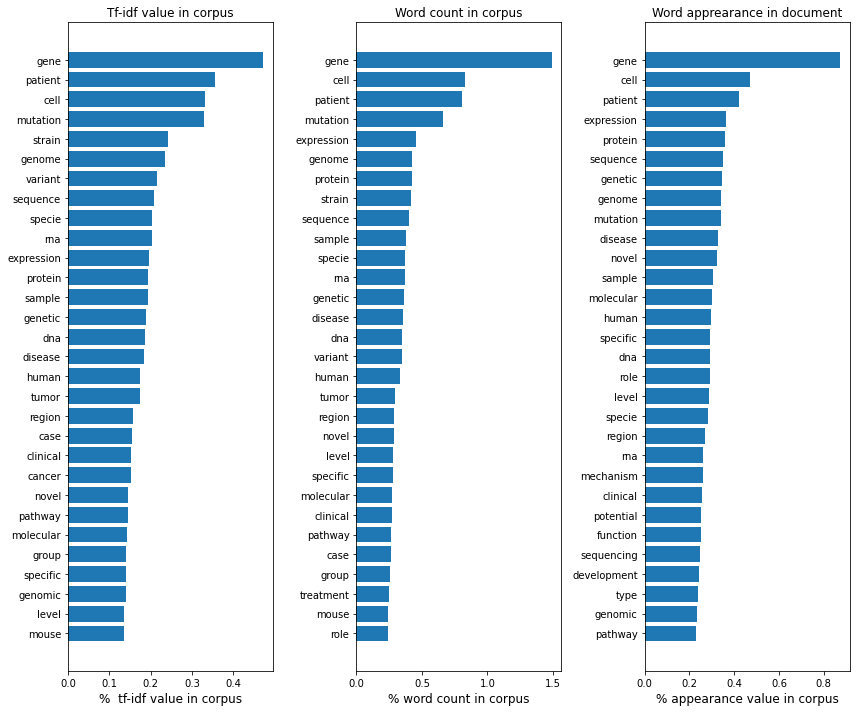

<Figure size 432x288 with 0 Axes>

In [259]:
#filter word and evaluate

md['GA'] = ft2
md['FA'] = md['GA'].apply(lambda x: ' '.join([word for word in x.split() if word not in (comm_sci_word)]))

fw = md['FA'].tolist()
tv, tt, cv, ct = tfidf_generator(fw, None)
df = wdf_generator(tv, tt, ct)
visualize_df(df, 30)
plt.tight_layout()
#plt.savefig('fig/lda/wbp.png', dpi=dpi)
plt.show()

## Visualize word distribution

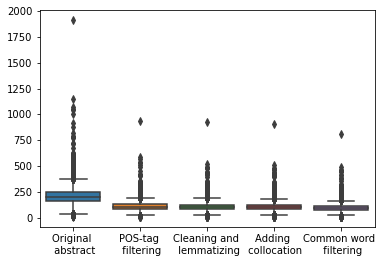

In [260]:
import seaborn as sns

md['abs_count'] = md[text_type1].str.split().str.len()
md['pa_count'] = md['PA'].str.split().str.len()
md['ca_count'] = md['CA'].str.split().str.len()
md['ga_count'] = md['GA'].str.split().str.len()
md['fa_count'] = md['FA'].str.split().str.len()

bdf = md[['abs_count', 'pa_count', 'ca_count', 'ga_count', 'fa_count']]
bdf.columns = ['Original \n abstract', 'POS-tag \n filtering', 'Cleaning and \n lemmatizing', 'Adding \n collocation', 'Common word \n filtering']

sns.boxplot(data= bdf)
#plt.savefig('fig/lda/pabpraw.png', dpi=dpi)
plt.show()

In [261]:
#Remove extreem outlier

md.sort_values(by= 'abs_count', ascending=False).head(20)
mdf = md.drop(index=7503)

In [4]:
#Load data

mdf = pd.read_csv('mt_country/call_tpf.csv')
dpi = 300

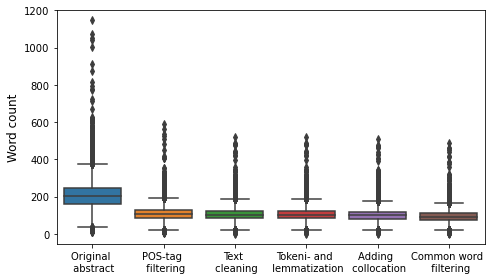

In [11]:
#Get figure

bdf2 = mdf[['abs_count', 'pa_count', 'ca_count', 'ca_count', 'ga_count', 'fa_count']]
bdf2.columns = ['Original \n abstract', 'POS-tag \n filtering', 'Text \n cleaning', 
                'Tokeni- and \n lemmatization', 'Adding \n collocation', 'Common word \n filtering']

fig, ax = plt.subplots(figsize = (7,4))
sns.boxplot(data= bdf2, ax=ax, palette = "tab10")
plt.ylabel('Word count', size=12)
plt.tight_layout()
plt.savefig('fig/lda/pabp.png', dpi=dpi)
plt.show()

In [22]:
#check boxplot statistic

from matplotlib.cbook import boxplot_stats

#boxplot_stats(bdf2['abs_count'])
#bdf2.describe()

## Final check

(21308, 82315) (21308, 82315)
82315


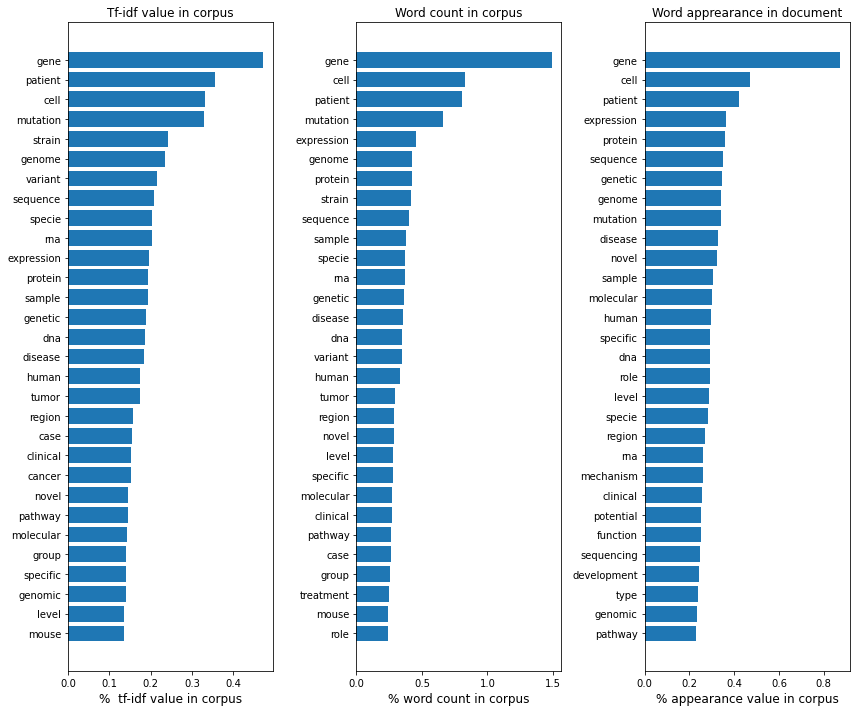

<Figure size 432x288 with 0 Axes>

In [263]:
fw = mdf['FA'].tolist()
tv, tt, cv, ct = tfidf_generator(fw, None)
df = wdf_generator(tv, tt, ct)
visualize_df(df, 30)
plt.tight_layout()

In [ ]:
df[df['word'].str.contains('_seq')]['word'].tolist()

## Export output

In [264]:
mdf['Clean Abstract'] = mdf['FA'].tolist() 

#md.to_csv('mt_country/'+code+'_tptest.csv', index = False)
mdf.to_csv('mt_country/call_tpf.csv', index = False)

In [265]:
dwn2.to_csv('mt_country/bigram_freq.csv', index = False)
dwn3.to_csv('mt_country/trigram_freq.csv', index = False)
md.sort_values(by = 'abs_count').to_csv('mt_country/call_tpbf.csv', index = False)

## Visualize word collocation

In [83]:
dwn2['word2'] = dwn2['word'].str.replace('[^a-zA-Z0-9,]', '')
dwn2['word2'] = dwn2['word2'].str.replace(',', '_')

dwn3['word2'] = dwn3['word'].str.replace('[^a-zA-Z0-9,]', '')
dwn3['word2'] = dwn3['word2'].str.replace(',', '_')

<ipython-input-83-5840e33042de>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  dwn2['word2'] = dwn2['word'].str.replace('[^a-zA-Z0-9,]', '')
<ipython-input-83-5840e33042de>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  dwn3['word2'] = dwn3['word'].str.replace('[^a-zA-Z0-9,]', '')


In [68]:
rnd= dwn2['word'][0]
rnd

"('gene', 'expression')"

In [62]:
check = dwn2['word'].apply(lambda x: '_'.join(x.split(', ')))
type(check)

pandas.core.series.Series

In [30]:
dwn2 = pd.read_csv('mt_country/bigram_freq.csv')
dwn3 = pd.read_csv('mt_country/ram_freq.csv')

In [27]:
#Original

twn2 = dwn2['word'].apply(lambda x: '_'.join(x)).tolist()
dwn2['word'] = twn2
hwn2 = dwn2.sort_values(by='counts',ascending = True).tail(20)

twn3 = dwn3['word'].apply(lambda x: '_'.join(x)).tolist()
dwn3['word'] = twn3
hwn3 = dwn3.sort_values(by='counts',ascending = True).tail(20)

In [84]:
#Alternative

dwn2['word2'] = dwn2['word'].str.replace('[^a-zA-Z0-9,]', '')
dwn2['word2'] = dwn2['word2'].str.replace(',', '_')
hwn2 = dwn2.sort_values(by='counts',ascending = True).tail(20)

dwn3['word2'] = dwn3['word'].str.replace('[^a-zA-Z0-9,]', '')
dwn3['word2'] = dwn3['word2'].str.replace(',', '_')
hwn3 = dwn3.sort_values(by='counts',ascending = True).tail(20)

<ipython-input-84-71225f0c823b>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  dwn2['word2'] = dwn2['word'].str.replace('[^a-zA-Z0-9,]', '')
<ipython-input-84-71225f0c823b>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  dwn3['word2'] = dwn3['word'].str.replace('[^a-zA-Z0-9,]', '')


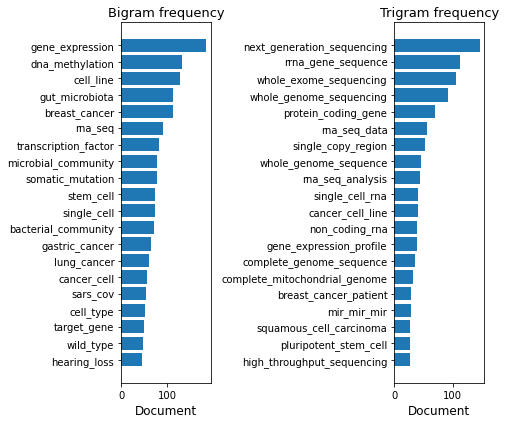

In [90]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(7,6))
ax1.barh(width = hwn2['counts'], y= hwn2['word2'].astype(str))
ax1.set_title('Bigram frequency', size =13)
ax1.set_xlabel('Document', size =12)

ax2.barh(width = hwn3['counts'], y= hwn3['word2'].astype(str))
ax2.set_title('Trigram frequency', size =13)
#plt.xticks(rotation=90, size=18); plt.yticks(size=14)
ax2.set_xlabel('Document', size =12)

plt.tight_layout()
plt.savefig('fig/lda/btcol.png', dpi=dpi)
plt.show()

In [16]:
mdf.loc[4498, [['FA', 'GA', 'PA']]]

Title_2            complete genome sequence of sphingorhabdus sp....
Year                                                          2018.0
Title              Complete genome sequence of Sphingorhabdus sp....
Abstract           Sphingorhabdus sp. YGSMI21 is a novel strain e...
Author Keywords                                                  NaN
Index Keywords     bacterial DNA; epoxide hydrolase; ribosome RNA...
Keywords Plus                                                    NaN
Mesh Term                                                        NaN
Source title                                    Genome Announcements
Document Type                                                Article
Authors            Kim H.-S., Cha S.H., Suk H.Y., Park N.-H., Woo...
Affiliations       Gyeongbuk Institute for Marine Bio-Industry (G...
Funding Details                                                  NaN
PMID                                                      dA2jCcSEag
DOI                               

## Temp

In [24]:
ccombined = []
rawl = []
for line in ft2:
    token = wt(line)
    raw = [w for w in token if (w.endswith(('ed', 'ing', 'ies')) & w.]
    oth = [w for w in token if not w.endswith(('ed', 'ing', 'ies'))]
#    stemw = [stemmer.stem(word) for word in raw]
    uni = ' '.join(raw + oth)
    ccombined.append(uni)
    rawl.append(raw)

md['RA'] = ccombined
md['RA'] = md['CA'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (<ipython-input-24-43848c4b3343>, line 5)

In [ ]:
'background', 'introduction', 'purpose', 'method', 'approach', 'result', 'conclusion', 'use', 'based', 'aim', 'due', 'with', 'data', 'many', 'addit', 'howev', 'there'

'high', 'low', 'common', 'new', 'differen', 'similar', 'distinc', 'total', 'several', 'type'

'ful', 'tly', 'cly', 'dly', 'ngly', 'hly', 'rily', 'aily', 'kly', 'lly', 'mly', 'nly', 'ely', 'rly', 'sly', 'ruly', 'wly' 
'ded', 'ted', 'ing', 'ies'

In [ ]:
stop_words = stopwords.words('english')
md['PA'] = md['PA'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [ ]:
#lmtzr.lemmatize('implies')
for line in fnn:
    word = stemmer.stem(line)
    print(word)

In [ ]:
lmtzr.lemmatize('clustering')
stemmer.stem('isolation')

In [ ]:
md['adjective']